In [103]:
import numpy as np
import IPython.display
import libs.utils as utils
import matplotlib.pyplot as plt
from libs.MVDR import MVbeamformer,MVbeamformer2
import libs.stft as stft
import scipy.signal as signal

%matplotlib inline

def calc_noise_coeff(noise, voice, snr, vad, ratio=1):
    coeff =  1.0 / np.linalg.norm(noise) * \
             np.linalg.norm(voice[vad > 0] * ratio) / 10.0 ** (0.05 * snr)
    #noise_ = noise * np.sqrt(np.mean(voice[vad>0] ** 2) / np.mean(noise **2) * (10.0 ** (-snr/10.0)))

    return coeff

def make_steering(n_frames, MicInterbal_m=0.03,NullAngle=np.pi/2,SoundVelocity=340,fs=16000,frame_size=1024, frame_shift=256,fftl=1024):
    hfftl = int(fftl/2) ###
    freqvec = fs / ((hfftl - 1) * 2) * np.matrix([i for i in range(hfftl)])
    omega = 2*np.pi*freqvec.T
    tau = MicInterbal_m*np.sin(NullAngle)/SoundVelocity
    e = np.exp(-1j*omega*tau)*np.ones((1, n_frames))
    return np.matrix(np.exp(-1j*omega*tau)), np.array(e)

def sougo_soukan(wav1,wav2, c=340, #sound verocity [m/s]
    d=0.06, # mic distant [m]
    fs=16000 #frame rate　16kだとフレーム数が少なすぎるので44.1kとかノほうがいい.
):
        # estimate speaker position by 相互相関法
    max_R=-2
    max_n=-2
    M=5000
    for n in range (M):
        sum1=0
        sum2=0
        sum3=0
        for i in range(M):
            sum1+=mixed1[i]*mixed4[(i+n)%N]
            sum2+=mixed1[i]**2
            sum3+=mixed4[i]**2
        Rn = sum1/np.sqrt(sum2*sum3)
        if Rn>max_R:
            max_R=Rn
            max_n=n
    print("max R:{}".format(max_R))
    print("max n:{}".format(max_n))

    #到来方向をけいさん
    a=(max_n+1)*(1/fs)*c/d
    rad= np.arccos(a)
    deg= np.degrees(rad)
    return deg


In [107]:
ch1=utils.read_int16_as_float32('3different_speech/left/in1_14.wav',fs=48000,Fs=16000)
ch2=utils.read_int16_as_float32('3different_speech/left/in4_13.wav',fs=48000,Fs=16000)
N=ch2.shape[0]
deg=sougo_soukan(ch2,ch1,d=0.06)
deg

c:\users\tanabehikari\miniconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


max R:0.856208724622848
max n:1


44.900527960688976

In [47]:
IPython.display.Audio(ch1,rate=16000)

In [96]:
# estimate speaker position by 相互相関法
max_R=-2
max_n=-2
M=1000
for n in range (-M,M):
    sum1=0
    sum2=0
    sum3=0
    for i in range(M):
        sum1+=ch1[i]*ch2[(i+n)]
        sum2+=ch1[i]**2
        sum3+=ch2[i]**2
        sum1+=ch1[-i]*ch2[-(i+n)]
        sum2+=ch1[-i]**2
        sum3+=ch2[-i]**2
    Rn = sum1/np.sqrt(sum2*sum3)
    if Rn>max_R:
        max_R=Rn
        max_n=n

print("max R:{}".format(max_R))
print("max n:{}".format(max_n))

max R:0.8645453031379859
max n:0


In [102]:
#到来方向をけいさん
c=340 #sound verocity [m/s]
d=0.06 # mic distant [m]
fs=16000 #frame rate　16kだとフレーム数が少なすぎるので44.1kとかノほうがいい.
a=(max_n+1)*(1/fs)*c/d
rad= np.arccos(a)
deg= np.degrees(rad)
deg

69.25762004551287

In [85]:
mixed1=utils.read_int16_as_float32('3different_speech/mixed/in1_13.wav',fs=48000,Fs=16000)
mixed4=utils.read_int16_as_float32('3different_speech/mixed/in4_12.wav',fs=48000,Fs=16000)
deg=sougo_soukan(mixed1,mixed4,d=0.06)
deg

c:\users\tanabehikari\miniconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


44.900527960688976

In [105]:
right1=utils.read_int16_as_float32('3different_speech/right/in1_18.wav',fs=48000,Fs=16000)
right4=utils.read_int16_as_float32('3different_speech/right/in4_18.wav',fs=48000,Fs=16000)
deg2=sougo_soukan(right1,right4,d=0.06)
IPython.display.Audio(right1,rate=16000)
deg2

c:\users\tanabehikari\miniconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


max R:0.856208724622848
max n:1


44.900527960688976

69.25762004551287

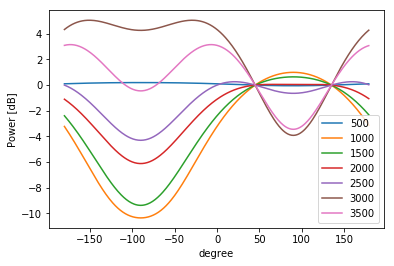

In [60]:
CH1,params = stft.stft(ch1)
omegaLength,timeLength = np.array(CH1).shape
n_frames = timeLength

y,w = MVbeamformer(ch1,ch2,45)
x=range(-180,180)
r=range(32,256,32) #32~256,32step
pw = []
for cnt,f in enumerate(r):
    pw=[]
    for i in x:
        a,_=make_steering( n_frames, NullAngle=np.pi/180*i)
        a=np.c_[np.ones(a.shape[0]), a].T
        #pw.append(np.trace(np.abs(np.conjugate(w.T)* a)))
        pw.append(np.abs(np.conjugate(w[:,f].T)* a[:,f])[0,0])
    plt.plot(x,20*np.log10(pw))
plt.xlabel('degree')
plt.ylabel('Power [dB]')
plt.legend([int(rr*(8000/512.0)) for rr in r])